In [2]:
import sys
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
# Custom KMeans class has been created, and can now be used for clustering
src_path = os.path.abspath(os.path.join('..', 'src'))
sys.path.append(src_path)
from kmeans import CustomKMeans, plot_clusters

# Import the cleaned data for use in the project
cleaned_data_path = os.path.abspath(os.path.join('..', 'data', 'cleaned', 'car_prices_cleaned.csv'))
car_df = pd.read_csv(cleaned_data_path)
car_df.head(5)

,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,mmr,sellingprice,saledate
0,2015,Kia,Sorento,LX,SUV,automatic,5xyktca69fg566472,ca,5.0,16639.0,white,black,"kia motors america, inc",20500,21500,2014-12-16
1,2015,Kia,Sorento,LX,SUV,automatic,5xyktca69fg561319,ca,5.0,9393.0,white,beige,"kia motors america, inc",20800,21500,2014-12-16
2,2014,BMW,3 Series,328i SULEV,Sedan,automatic,wba3c1c51ek116351,ca,4.5,1331.0,gray,black,financial services remarketing (lease),31900,30000,2015-01-14
3,2015,Volvo,S60,T5,Sedan,automatic,yv1612tb4f1310987,ca,4.1,14282.0,white,black,volvo na rep/world omni,27500,27750,2015-01-28
4,2014,BMW,6 Series Gran Coupe,650i,Sedan,automatic,wba6b2c57ed129731,ca,4.3,2641.0,gray,black,financial services remarketing (lease),66000,67000,2014-12-18


Possible Observations (Observations 1-2 Patrick B):

Observation 1: Why do some cars with identical attributes sell for significantly different prices?

Hypotheses:
The sellers could be located in different regions with varying demand or pricing trends.
One car might have additional features, trim upgrades, or warranties that weren’t recorded in the dataset.
Price discrepancies could result from negotiation differences or auction dynamics.

Observation 2: Why are there cars with extremely high condition ratings (for example 4.9 or 5.0) but very low prices? 
Hypotheses:
These could be compact or economy cars, which generally have lower market prices despite excellent condition.
The condition score might be subjective or inflated, not reflecting the actual value.
There might have been a mistake in recording the selling price.

Significant Price Differences in Identical Groups:
        year      make           model  condition  odometer  count  min_price  \
191511  2011      Ford           F-150        4.0  103926.0      2       9800   
338913  2013      Ford           F-150        4.8   24150.0      2      16400   
406043  2014  Chrysler             200        4.4   23698.0      2      11500   
435783  2014   Hyundai  Santa Fe Sport        5.0      10.0      2      13200   
468565  2015      Jeep        Wrangler        4.0       5.0      2      18200   

        max_price  price_range  
191511      21400        11600  
338913      27000        10600  
406043      31000        19500  
435783      27900        14700  
468565      35200        17000  
Cars with Significant Price Differences Despite Identical Attributes:
   year      make           model              trim       body transmission  \
0  2014  Chrysler             200           Touring      Sedan    automatic   
1  2015      Jeep        Wrangler  U

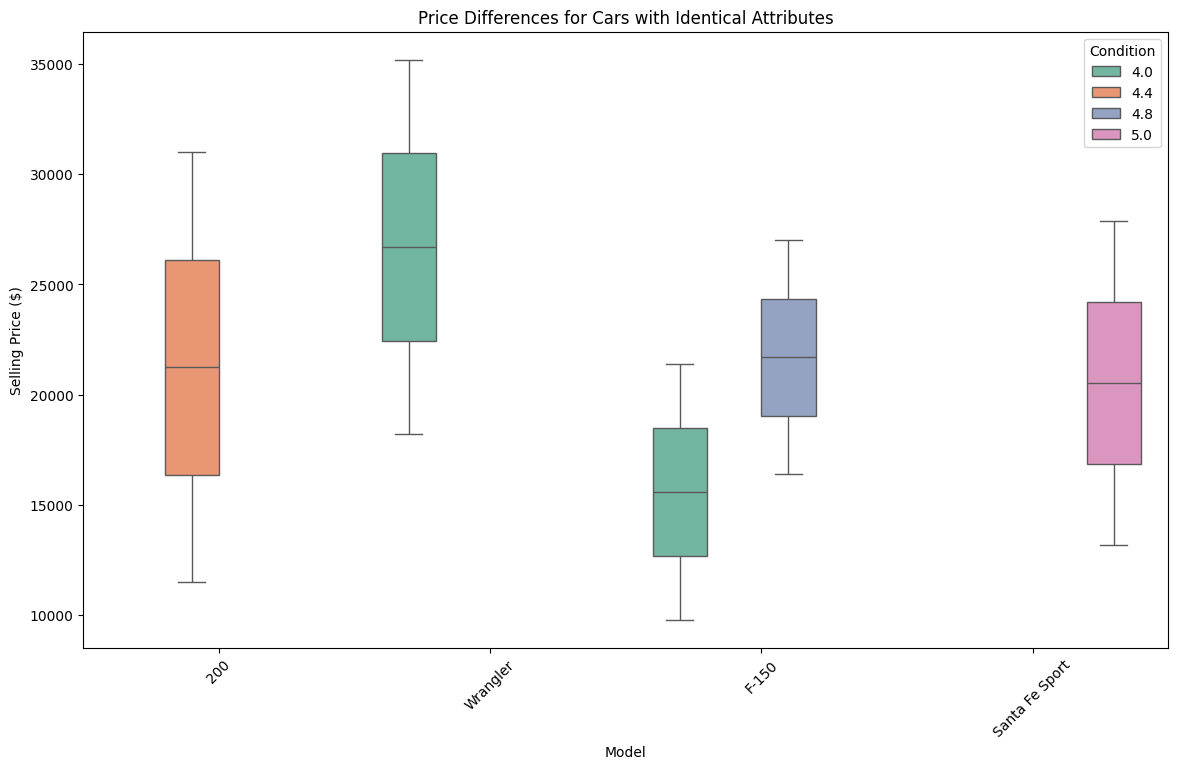

In [ ]:
#Observation 1 Differences in Cars with the Same Attributes:

# Group Cars by year, odometer, condition, make, and model
key_attributes = ['year', 'make', 'model', 'condition', 'odometer']
grouped = car_df.groupby(key_attributes).agg(
    count=('sellingprice', 'size'),
    min_price=('sellingprice', 'min'),
    max_price=('sellingprice', 'max'),
    price_range=('sellingprice', lambda x: x.max() - x.min())
).reset_index()

price_difference_threshold = 10000  # Set a significant price difference
significant_differences = grouped[grouped['price_range'] > price_difference_threshold]

print("Significant Price Differences in Identical Groups:")
print(significant_differences)

#This DataFrame contains the actual cars from the dataframe 
#that belong to the groups identified in significant_differences
significant_groups = car_df.merge(
    significant_differences[key_attributes],
    on=key_attributes,
    how='inner'
)

print("Cars with Significant Price Differences Despite Identical Attributes:")
print(significant_groups)

#Box plot of the findings
plt.figure(figsize=(14, 8))
sns.boxplot(
    data=significant_groups,
    x='model',
    y='sellingprice',
    hue='condition',
    palette='Set2'
)
plt.title('Price Differences for Cars with Identical Attributes')
plt.xlabel('Model')
plt.ylabel('Selling Price ($)')
plt.legend(title='Condition')
plt.xticks(rotation=45)
plt.show()

I investigated cars with the same attributes such as year, make, model, condition, and odometer that showcased substantial differences in the pricing. The dataset was grouped based on these key attributes. The analysis showcased cars with identical or near-identical attributes but significat differences in the price. For example:
* A 2014 Chrysler 200 with 23,698 miles and condition 4.4 had a price range from $11,500 to $31,000, a difference of $19,500.
* A 2013 Ford F-150, condition 4.8, with only 24,150 miles had a price range of $10,600, ranging from $16,400 to $27,000.

The main explination for this seems to be the differences in trim levels, as well as the possible demand in those regions.